In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\data\Ultrasound Fetus Dataset\FetusDataset.csv")
target_col = 'fetal_health'
X = df.drop(columns=[target_col])
y_raw = df[target_col]
le = LabelEncoder()
y = le.fit_transform(y_raw)

X = X.fillna(X.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

models = {}
try:
    from xgboost import XGBClassifier
    models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_estimators=100, n_jobs=1)
except Exception:
    models['XGBoost (sklearn fallback)'] = GradientBoostingClassifier(random_state=42, n_estimators=100)

models['RandomForest'] = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)
models['DecisionTree'] = DecisionTreeClassifier(random_state=42)
models['LogisticRegression'] = LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42)
models['SVM'] = SVC(probability=True, random_state=42)
models['KNN'] = KNeighborsClassifier(n_neighbors=5)
models['NaiveBayes'] = GaussianNB()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'accuracy':'accuracy','precision':'precision_macro','recall':'recall_macro','f1':'f1_macro'}

results_cv = {}
for name, model in models.items():
    scores = cross_validate(model, X_scaled, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=1)
    results_cv[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}

test_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        try:
            auc = roc_auc_score(pd.get_dummies(y_test), y_proba, average='macro')
        except Exception:
            auc = None
    else:
        auc = None
    test_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'auc_macro_ovr': auc,
        'classification_report': classification_report(y_test, y_pred, digits=4, target_names=[str(c) for c in le.classes_])
    }

import pprint
print("Label mapping (original -> encoded):")
pprint.pprint(dict(zip(le.classes_, le.transform(le.classes_))))
print("\nCross-validation (5-fold Stratified) mean scores:")
pprint.pprint(results_cv)
print("\nTest set results:")
for name, res in test_results.items():
    print(f"\n=== {name} ===")
    print("Accuracy:", res['accuracy'])
    print("Precision (macro):", res['precision'])
    print("Recall (macro):", res['recall'])
    print("F1 (macro):", res['f1'])
    print("AUC (macro, OVR):", res['auc_macro_ovr'])
    print("Classification report:\n", res['classification_report'])


Label mapping (original -> encoded):
{np.float64(1.0): np.int64(0),
 np.float64(2.0): np.int64(1),
 np.float64(3.0): np.int64(2)}

Cross-validation (5-fold Stratified) mean scores:
{'DecisionTree': {'accuracy': np.float64(0.9125103562551781),
                  'f1': np.float64(0.8562849143349739),
                  'precision': np.float64(0.8545382963210016),
                  'recall': np.float64(0.8602845476581971)},
 'KNN': {'accuracy': np.float64(0.9063949185307927),
         'f1': np.float64(0.8221192706587723),
         'precision': np.float64(0.8684573230531875),
         'recall': np.float64(0.7891401743872429)},
 'LogisticRegression': {'accuracy': np.float64(0.896051919359293),
                        'f1': np.float64(0.796746043915319),
                        'precision': np.float64(0.8213490649355437),
                        'recall': np.float64(0.7792916706967605)},
 'NaiveBayes': {'accuracy': np.float64(0.7431980115990058),
                'f1': np.float64(0.666050321129

Label mapping (original -> encoded):

np.float64(1.0): np.int64(0), : Normal

 np.float64(2.0): np.int64(1),: Benign
 
 np.float64(3.0): np.int64(2),: Malignant

In [11]:
print(np.unique(y)) 

[0 1 2]


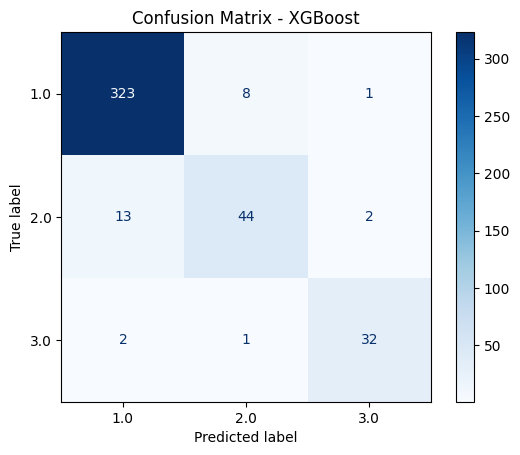

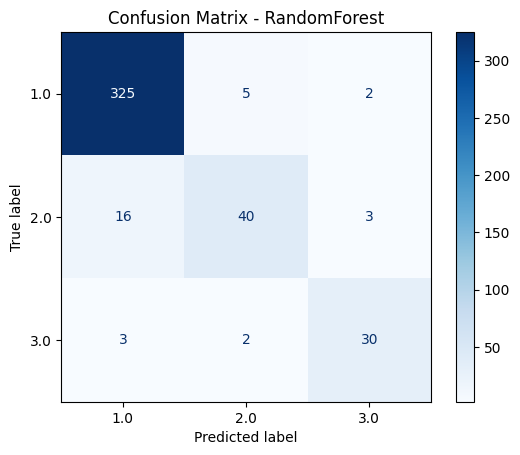

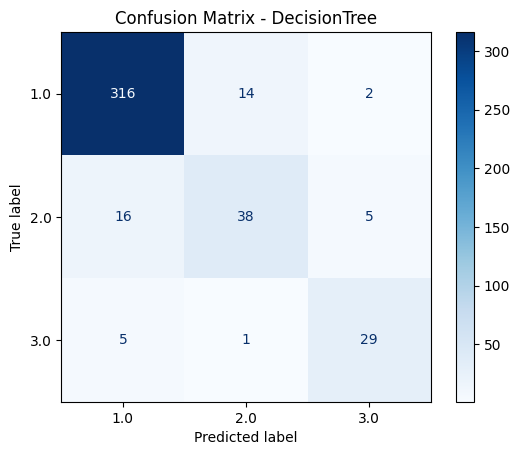

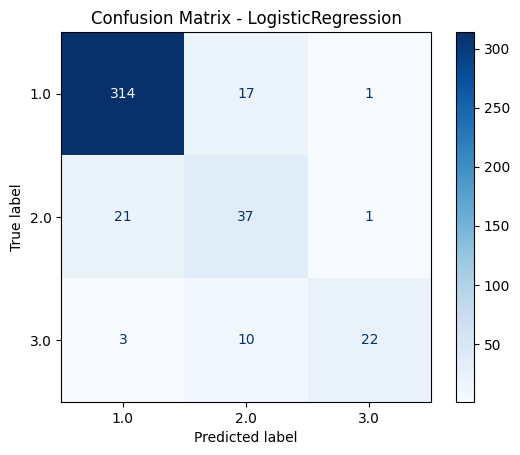

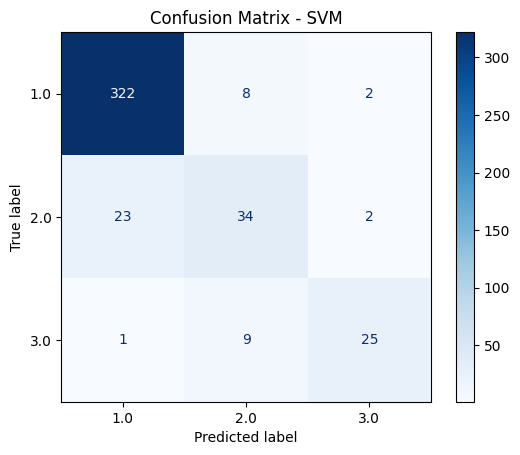

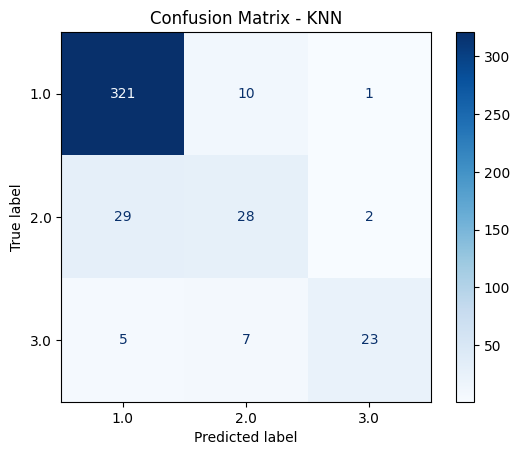

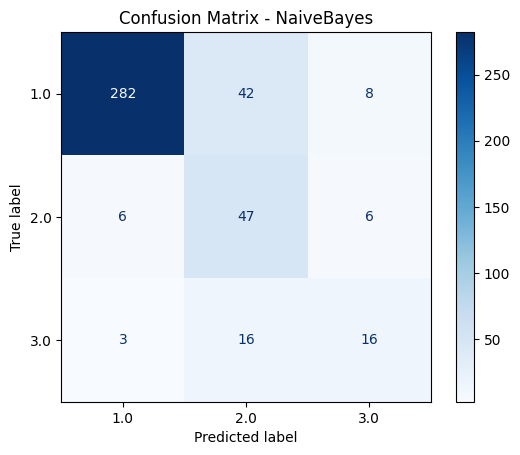

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in models.items():
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=le.classes_, cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


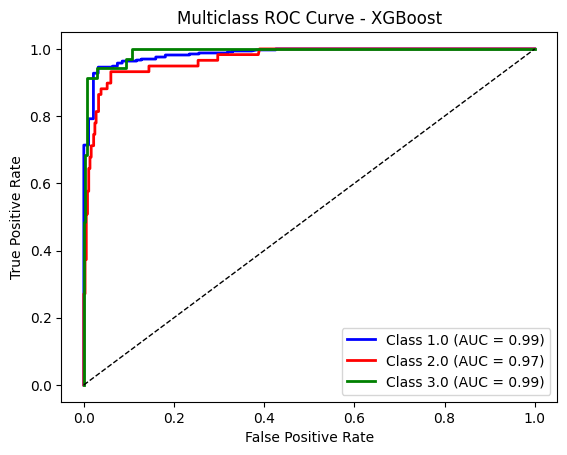

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_bin = label_binarize(y_test, classes=[0,1,2])
n_classes = y_bin.shape[1]
y_score = models['XGBoost'].predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()


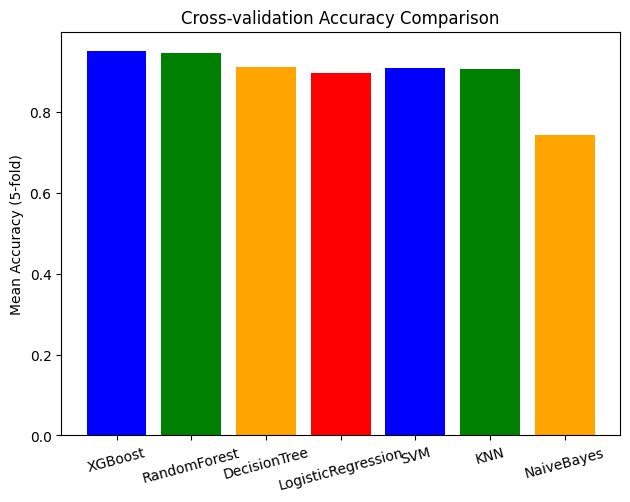

In [20]:
import matplotlib.pyplot as plt

cv_scores = [results_cv[m]['accuracy'] for m in results_cv]
plt.bar(results_cv.keys(), cv_scores, color=['blue','green','orange','red'])
plt.title("Cross-validation Accuracy Comparison")
plt.ylabel("Mean Accuracy (5-fold)")
plt.tight_layout()
plt.xticks(rotation=15)
plt.show()


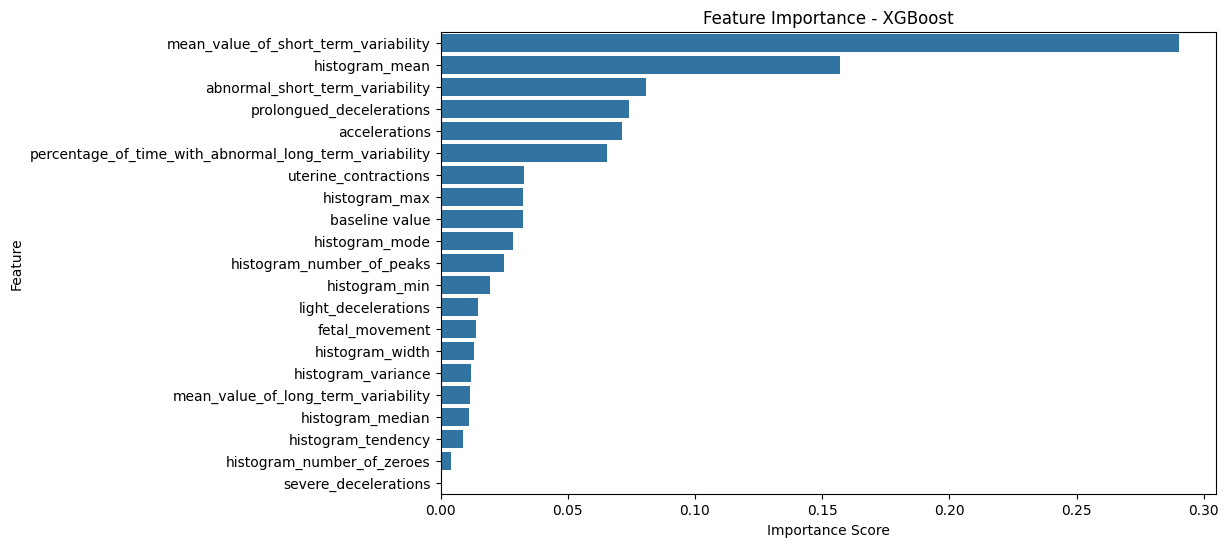

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model = models['XGBoost']
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=np.array(X.columns)[indices])
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


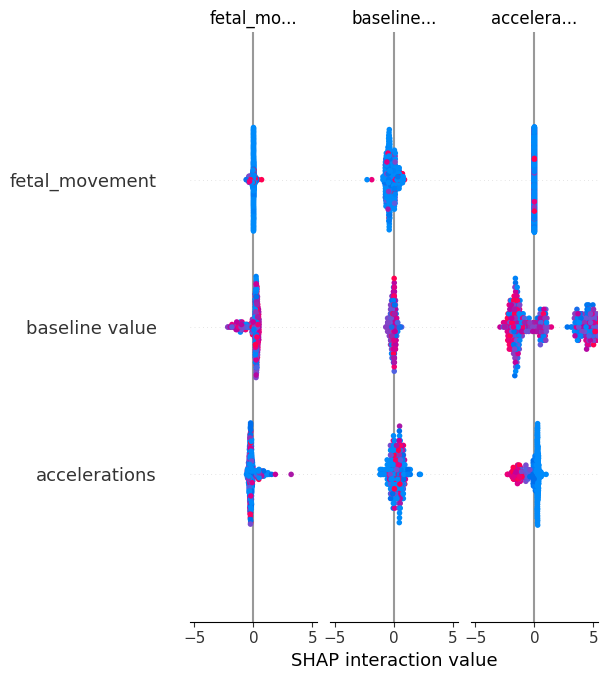

In [16]:
import shap
explainer = shap.TreeExplainer(models['XGBoost'])
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)


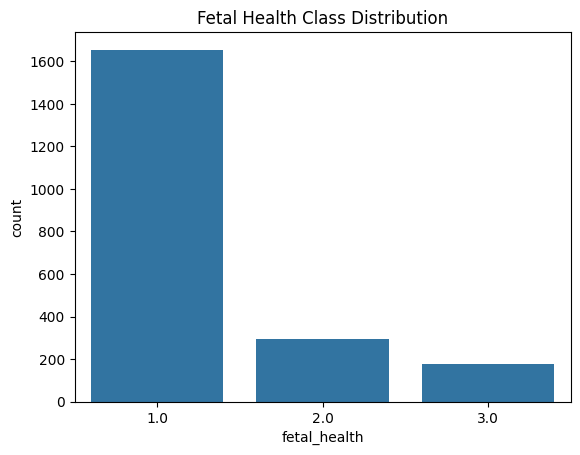

In [17]:
import seaborn as sns
sns.countplot(x='fetal_health', data=df)
plt.title('Fetal Health Class Distribution')
plt.show()


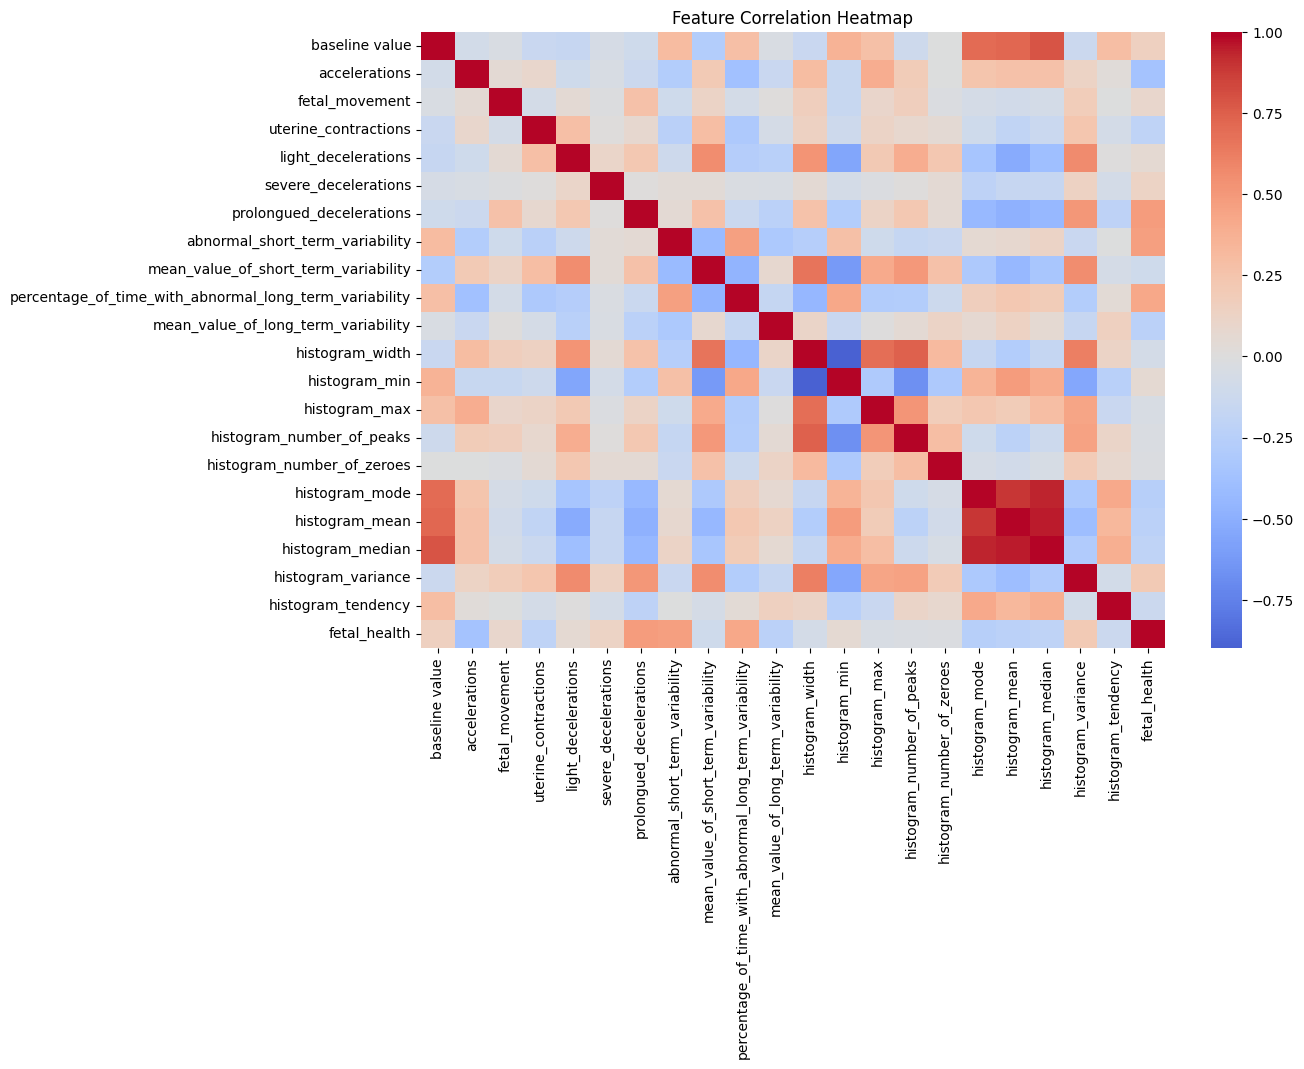

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


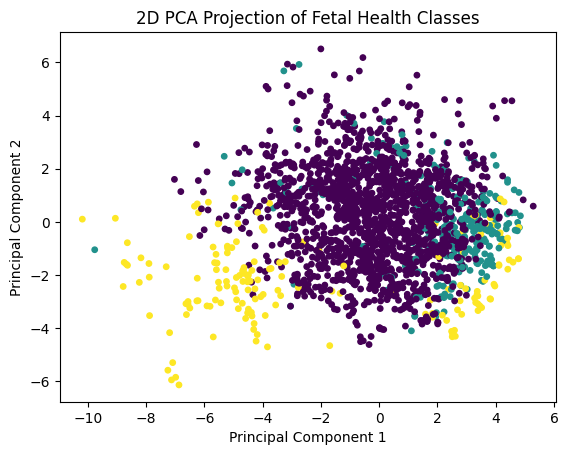

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', s=15)
plt.title("2D PCA Projection of Fetal Health Classes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


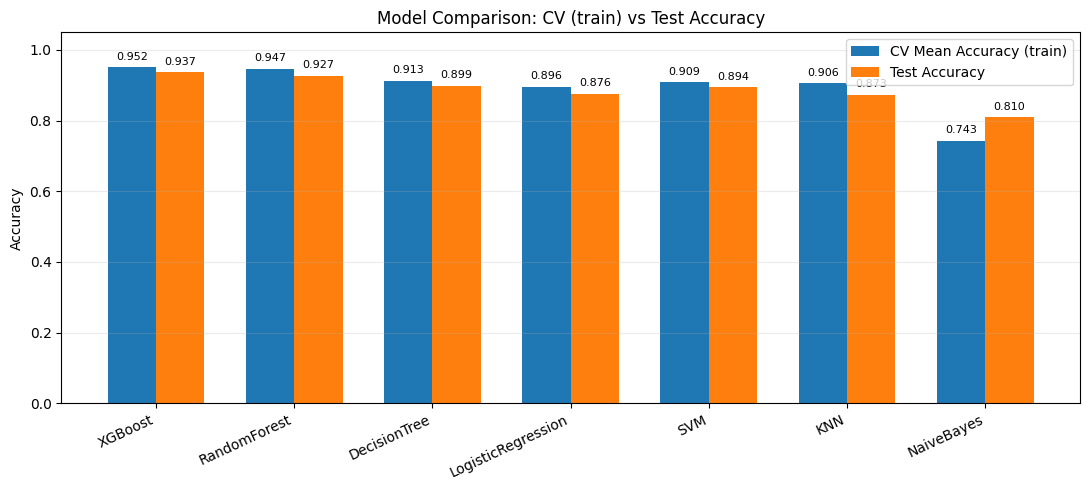

In [22]:
import numpy as np

# Grouped bar chart: cross-validation (train) vs test accuracy for all models

model_names = list(results_cv.keys())
train_acc = [results_cv[m]['accuracy'] for m in model_names]
test_acc = [test_results[m]['accuracy'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(11,5))
bars1 = plt.bar(x - width/2, train_acc, width, label='CV Mean Accuracy (train)', color='tab:blue')
bars2 = plt.bar(x + width/2, test_acc,  width, label='Test Accuracy', color='tab:orange')

plt.ylim(0, 1.05)
plt.ylabel('Accuracy')
plt.title('Model Comparison: CV (train) vs Test Accuracy')
plt.xticks(x, model_names, rotation=25, ha='right')
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.25)

# annotate bars with values
for b in bars1 + bars2:
    h = b.get_height()
    plt.annotate(f'{h:.3f}', xy=(b.get_x() + b.get_width() / 2, h),
                 xytext=(0, 4), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [23]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pprint
from scipy.stats import randint

# Tune XGBoost (best performing). uses existing models['XGBoost']
xgb = models['XGBoost']

xgb_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'min_child_weight': [1, 3, 5]
}

rs_xgb = RandomizedSearchCV(
    xgb,
    xgb_param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=cv,
    random_state=42,
    n_jobs=1,
    verbose=1
)

rs_xgb.fit(X_train, y_train)
best_xgb = rs_xgb.best_estimator_

print("XGBoost best params:")
pprint.pprint(rs_xgb.best_params_)
print("Best CV score (f1_macro):", rs_xgb.best_score_)

# Evaluate tuned XGBoost on test set
y_pred = best_xgb.predict(X_test)
if hasattr(best_xgb, "predict_proba"):
    y_proba = best_xgb.predict_proba(X_test)
    try:
        auc = roc_auc_score(pd.get_dummies(y_test), y_proba, average='macro')
    except Exception:
        auc = None
else:
    auc = None

tuned_res = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
    'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
    'f1': f1_score(y_test, y_pred, average='macro', zero_division=0),
    'auc_macro_ovr': auc,
    'classification_report': classification_report(y_test, y_pred, digits=4, target_names=[str(c) for c in le.classes_])
}

print("\nTuned XGBoost test results:")
pprint.pprint(tuned_res)

# Save tuned model into models dict and update test_results & results_cv for comparison
models['XGBoost_tuned'] = best_xgb
test_results['XGBoost_tuned'] = tuned_res
results_cv['XGBoost_tuned'] = {'accuracy': np.nan, 'precision': np.nan, 'recall': np.nan, 'f1': rs_xgb.best_score_}

# Optional: quick RandomForest tuning (small search)
rf = models['RandomForest']
rf_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 8, 12, 16],
    'max_features': ['sqrt', 'log2', 0.6, 0.8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rs_rf = RandomizedSearchCV(rf, rf_param_dist, n_iter=20, scoring='f1_macro', cv=cv, random_state=42, n_jobs=1, verbose=0)
rs_rf.fit(X_train, y_train)
best_rf = rs_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test) if hasattr(best_rf, "predict_proba") else None
try:
    auc_rf = roc_auc_score(pd.get_dummies(y_test), y_proba_rf, average='macro') if y_proba_rf is not None else None
except Exception:
    auc_rf = None

rf_res = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf, average='macro', zero_division=0),
    'recall': recall_score(y_test, y_pred_rf, average='macro', zero_division=0),
    'f1': f1_score(y_test, y_pred_rf, average='macro', zero_division=0),
    'auc_macro_ovr': auc_rf,
    'classification_report': classification_report(y_test, y_pred_rf, digits=4, target_names=[str(c) for c in le.classes_])
}

print("\nRandomForest best params:")
pprint.pprint(rs_rf.best_params_)
print("\nTuned RandomForest test results:")
pprint.pprint(rf_res)

models['RandomForest_tuned'] = best_rf
test_results['RandomForest_tuned'] = rf_res
results_cv['RandomForest_tuned'] = {'accuracy': np.nan, 'precision': np.nan, 'recall': np.nan, 'f1': rs_rf.best_score_}

Fitting 5 folds for each of 30 candidates, totalling 150 fits
XGBoost best params:
{'colsample_bytree': 0.6,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 300,
 'subsample': 0.6}
Best CV score (f1_macro): 0.924391336094143

Tuned XGBoost test results:
{'accuracy': 0.9342723004694836,
 'auc_macro_ovr': 0.9802594317287888,
 'classification_report': '              precision    recall  f1-score   '
                          'support\n'
                          '\n'
                          '         1.0     0.9529    0.9759    0.9643       '
                          '332\n'
                          '         2.0     0.8400    0.7119    0.7706        '
                          '59\n'
                          '         3.0     0.8889    0.9143    0.9014        '
                          '35\n'
                          '\n'
                          '    accuracy                         0.9343       '
                          '426\n'


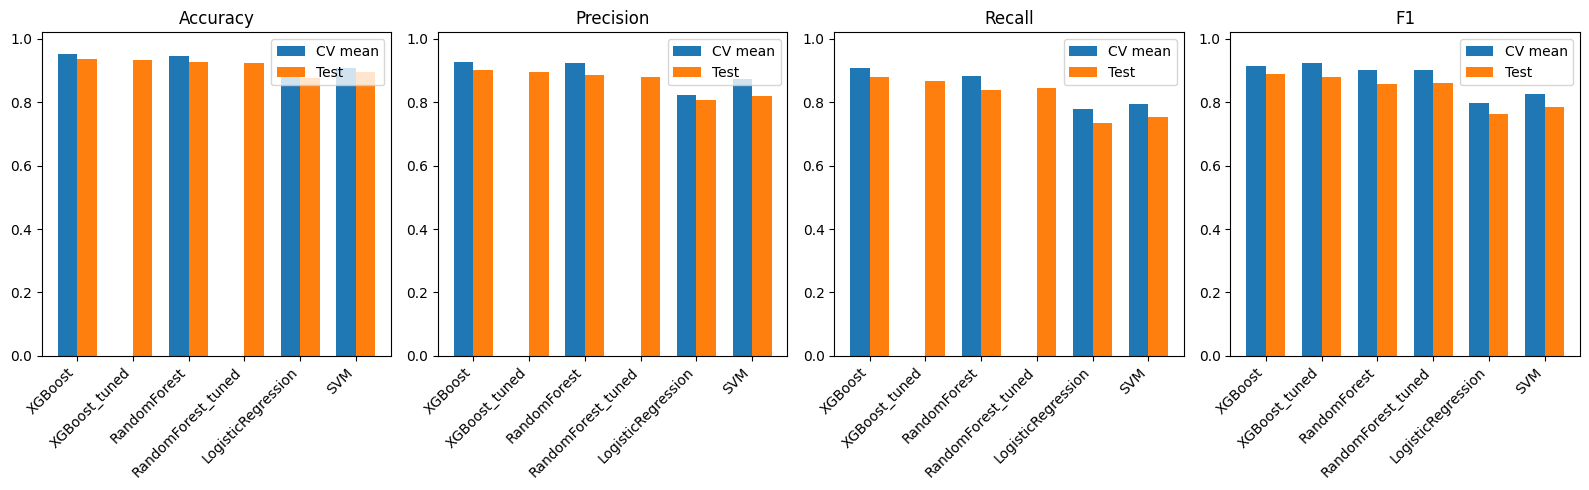

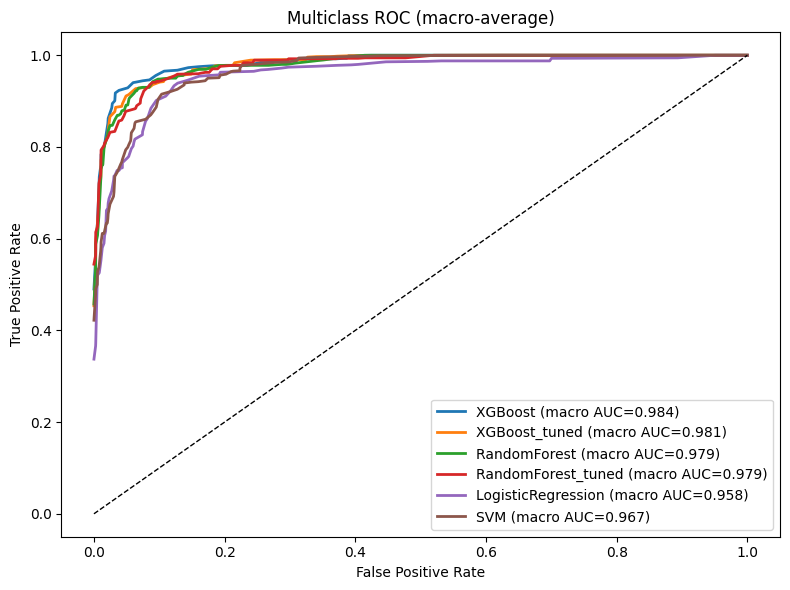

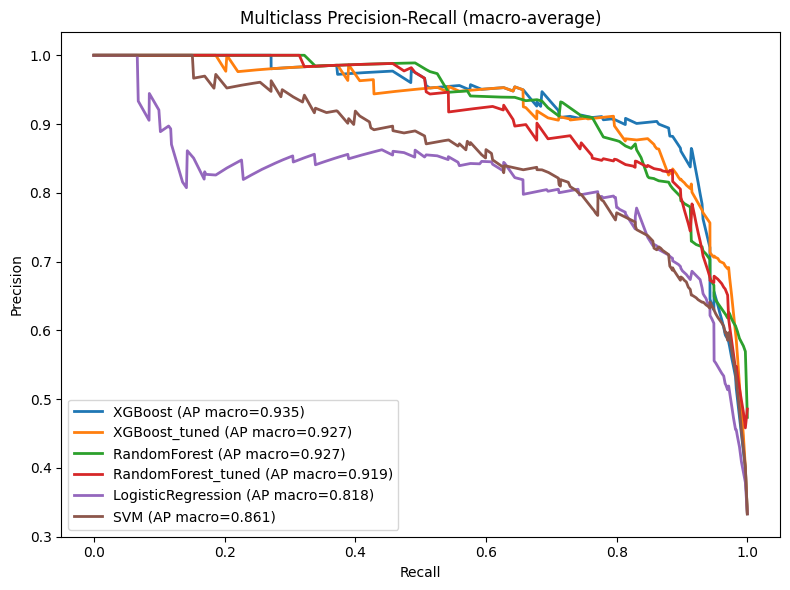

In [24]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

import matplotlib.pyplot as plt

# pick models to visualize (only those present)
plot_models = [m for m in ['XGBoost','XGBoost_tuned','RandomForest','RandomForest_tuned','LogisticRegression','SVM'] if m in models]

# 1) CV vs Test: accuracy / precision / recall / f1 (grouped)
metrics = ['accuracy','precision','recall','f1']
M = len(plot_models)
x = np.arange(M)
width = 0.35

fig, axes = plt.subplots(1, len(metrics), figsize=(4*len(metrics), 5))
if len(metrics) == 1:
    axes = [axes]
for i, metric in enumerate(metrics):
    cv_vals = [results_cv.get(m, {}).get(metric, np.nan) for m in plot_models]
    test_vals = [test_results.get(m, {}).get(metric, np.nan) for m in plot_models]
    axes[i].bar(x - width/2, cv_vals, width, label='CV mean')
    axes[i].bar(x + width/2, test_vals, width, label='Test')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(plot_models, rotation=45, ha='right')
    axes[i].set_title(metric.capitalize())
    axes[i].set_ylim(0, 1.02)
    axes[i].legend()
plt.tight_layout()
plt.show()

# prepare binarized test labels for multiclass curves
y_bin = label_binarize(y_test, classes=np.arange(n_classes))

# helper to get predict_proba if available
def get_proba(m, X):
    try:
        return m.predict_proba(X)
    except Exception:
        return None

# 2) Multiclass ROC - macro-average per model
fig, ax = plt.subplots(figsize=(8,6))
for name in plot_models:
    model = models[name]
    y_score = get_proba(model, X_test)
    if y_score is None:
        continue
    # per-class ROC
    fpr = {}
    tpr = {}
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_bin[:, j], y_score[:, j])
    # aggregate for macro-average
    all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
    mean_tpr /= n_classes
    roc_auc = auc(all_fpr, mean_tpr)
    ax.plot(all_fpr, mean_tpr, lw=2, label=f'{name} (macro AUC={roc_auc:.3f})')

ax.plot([0,1],[0,1],'k--', lw=1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Multiclass ROC (macro-average)')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 3) Multiclass Precision-Recall (macro-average) per model
fig, ax = plt.subplots(figsize=(8,6))
for name in plot_models:
    model = models[name]
    y_score = get_proba(model, X_test)
    if y_score is None:
        continue
    # compute per-class precision-recall and average-precision
    all_recall = np.unique(np.concatenate([precision_recall_curve(y_bin[:, j], y_score[:, j])[1] for j in range(n_classes)]))
    mean_precision = np.zeros_like(all_recall)
    aps = []
    for j in range(n_classes):
        p, r, _ = precision_recall_curve(y_bin[:, j], y_score[:, j])
        # ensure recall is increasing for interp
        order = np.argsort(r)
        r_s, p_s = r[order], p[order]
        mean_precision += np.interp(all_recall, r_s, p_s)
        aps.append(average_precision_score(y_bin[:, j], y_score[:, j]))
    mean_precision /= n_classes
    ap_macro = np.mean(aps)
    ax.plot(all_recall, mean_precision, lw=2, label=f'{name} (AP macro={ap_macro:.3f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Multiclass Precision-Recall (macro-average)')
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()